**This script is to take in the ouput generated by Quadric SLAM and align it with Ground Truth and export both Ground Truth and aligned estimated camera and object poses into a json file.**

## Import Modules

In [1]:
import os
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from typing import List
import math
from matplotlib.patches import Patch
from distinctipy import get_colors # to get unique colors
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from itertools import product
from numpy.linalg import LinAlgError, eigvalsh

%matplotlib notebook

In [2]:
# BOP YCBV dataset
dataset_info = {'1': 'master_chef_can',
                '2': 'cracker_box',
                '3': 'sugar_box',
                '4': 'tomato_soup_can',
                '5': 'mustard_bottle',
                '6': 'tuna_fish_can',
                '7': 'pudding_box',
                '8': 'gelatin_box',
                '9': 'potted_meat_can',
                '10': 'banana',
                '11': 'pitcher_base',
                '12': 'bleach_cleanser',
                '13': 'bowl',
                '14': 'mug',
                '15': 'power_drill',
                '16': 'wood_block',
                '17': 'scissors',
                '18': 'large_marker',
                '19': 'large_clamp',
                '20': 'extra_large_clamp',
                '21': 'foam_brick'}

In [3]:
# Folder containing the BOP dataset formated files
gt_data_path = "/home/allen/Desktop/RnD_Github/AllenIsaacRnD/dataset/000001/"
# Folder containing the file generated by QuadricSLAM
output_data_path = gt_data_path + "quadric_slam_result/"
# Load the GT models
model_path = '/home/allen/Desktop/RnD_Github/AllenIsaacRnD/dataset/'
# Export file data path
export_path = output_data_path

# VISUALISATION FUNCTIONS

## Function to plot ellipsoids

In [4]:
# Reference - https://github.com/qcr/quadricslam/blob/master/src/quadricslam/visualisation.py
def plot_ellipsoid(pose: np.ndarray, radii: np.ndarray, ax: matplotlib.figure.Axes, color):
    # Generate ellipsoid of appropriate size at origin
    SZ = 50
    radii = np.abs(radii)
    u, v = np.linspace(0, 2 * np.pi, SZ), np.linspace(0, np.pi, SZ)
    x, y, z = (radii[0] * np.outer(np.cos(u), np.sin(v)),
               radii[1] * np.outer(np.sin(u), np.sin(v)),
               radii[2] * np.outer(np.ones_like(u), np.cos(v)))

    # Rotate the ellipsoid, then translate to centroid
    ps = pose @ np.vstack([
        x.reshape(-1),
        y.reshape(-1),
        z.reshape(-1),
        np.ones(z.reshape(-1).shape)
    ])

    # Plot the ellipsoid
    ax.plot_wireframe(
        ps[0, :].reshape(SZ, SZ),
        ps[1, :].reshape(SZ, SZ),
        ps[2, :].reshape(SZ, SZ),
        rstride=4,
        cstride=4,
        color=color,
        linewidth=0.5,
    )

## Function to plot cuboids

In [5]:
def plot_cuboid(pose: np.ndarray, size: np.ndarray, ax: matplotlib.figure.Axes, color):
    # Get all 8 corner points of the cuboid
    #vertices = np.array(list(product(*zip(pose[:3, -1] - 0.5 * size, pose[:3, -1] + 0.5 * size))))
    vertices = np.array(list(product(*zip(- 0.5 * size, + 0.5 * size))))
    
    # Transform the cuboid's vertices using the pose matrix
    t_vertices = np.dot(pose[:3, :3], vertices.T).T + pose[:3, -1]
    
    # Define the edges of the cuboid using the vertices
    edges = [
        [t_vertices[0], t_vertices[1]], [t_vertices[1], t_vertices[5]], [t_vertices[5], t_vertices[4]],
        [t_vertices[4], t_vertices[0]], [t_vertices[7], t_vertices[6]], [t_vertices[6], t_vertices[2]],
        [t_vertices[2], t_vertices[3]], [t_vertices[3], t_vertices[7]], [t_vertices[0], t_vertices[2]],
        [t_vertices[1], t_vertices[3]], [t_vertices[4], t_vertices[6]], [t_vertices[5], t_vertices[7]]
    ]
    
    ax.add_collection3d(Line3DCollection(edges, colors=color, linewidths=2))

## Function to plot trajectory

In [6]:
def plot_traj(data: List, ax: matplotlib.figure.Axes, length = 50, c:str = 'cyan', label = None):
    
    # to plot trajectory
    traj = []
    
    for idx in range(len(data)):
        # position
#         ax.scatter(data[idx][0,-1], data[idx][1,-1], data[idx][2,-1], c='r', marker='*')
        # orientation
        if idx % 30 == 0:
            # X
            ax.quiver(data[idx][0,-1], data[idx][1,-1], data[idx][2,-1],
                      data[idx][0, 0], data[idx][1, 0], data[idx][2, 0],
                      color='b', length=length, linewidth=0.2, alpha=1)
            # Y
            ax.quiver(data[idx][0,-1], data[idx][1,-1], data[idx][2,-1],
                      data[idx][0, 1], data[idx][1, 1], data[idx][2, 1],
                      color='g', length=length, linewidth=0.2, alpha=1)
            # Z
            ax.quiver(data[idx][0,-1], data[idx][1,-1], data[idx][2,-1],
                      data[idx][0, 2], data[idx][1, 2], data[idx][2, 2],
                      color='r', length=length, linewidth=0.2, alpha=1)
        
        traj.append([data[idx][0,-1], data[idx][1,-1], data[idx][2,-1]])
        
    #trajectory
    if c != 'cyan':
        traj = np.array(traj)
        if label==None:
            ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color=c)
        else:
            ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color=c, label = label)
        
    
    return None

# GROUND TRUTH

## Ground Truth Camera Poses

In [7]:
f = open(gt_data_path + 'scene_camera.json')
camera_pose = json.load(f)

In [8]:
camera_pose['1']

{'cam_K': [888.888916015625, 0.0, 320.0, 0.0, 1000.0, 240.0, 0.0, 0.0, 1.0],
 'cam_R_w2c': [-0.010667284841447005,
  0.999943128231413,
  -1.2224512473303287e-07,
  0.7294956916080259,
  0.007782097982984404,
  -0.6839411288783406,
  -0.6839022202746295,
  -0.007295884127515349,
  -0.7295372220995026],
 'cam_t_w2c': [0.00010460249741280303,
  2.8878463721240762e-05,
  2193.171271047776],
 'depth_scale': 10}

### Plotting Ground Truth Camera Trajectory

<IPython.core.display.Javascript object>


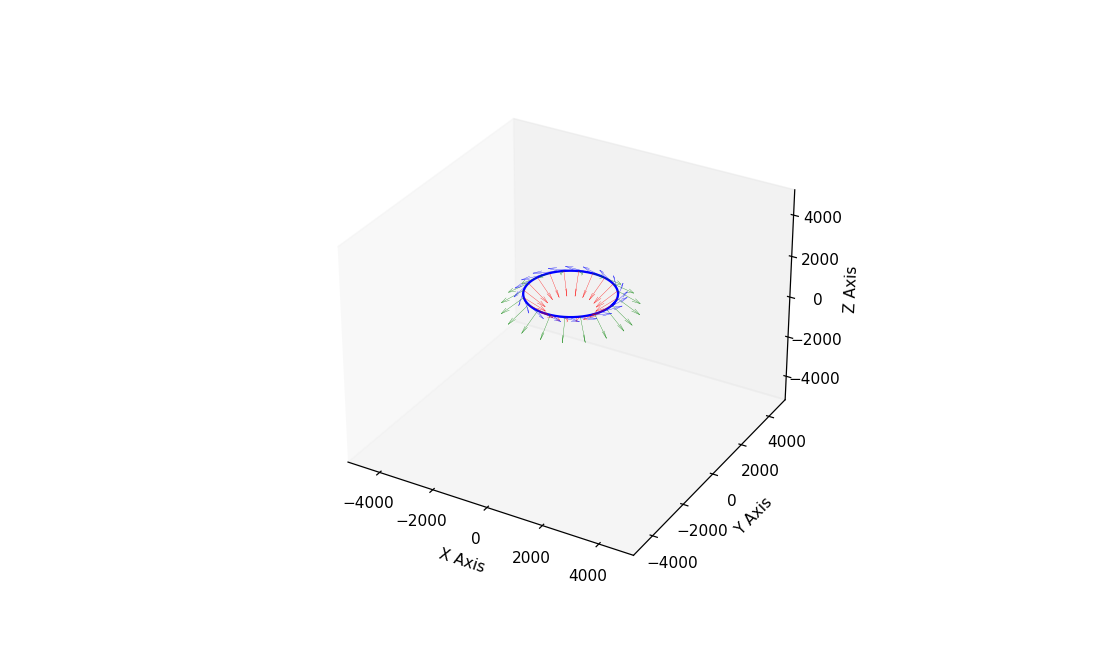

In [10]:
gt_traj = []

for c in camera_pose:
    
    world2camera = np.column_stack((np.array(camera_pose[c]['cam_R_w2c']).reshape(3,3),
                                    np.array(camera_pose[c]['cam_t_w2c']).reshape(3,1)))
    world2camera = np.row_stack((world2camera, np.array([0. , 0., 0., 1.])))
    
    # In the dataset, the transformation is w2c(world with respect to the camera)
    # we need to change it to camera with respect to the world.
    gt_traj.append(np.linalg.inv(world2camera))


fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('X Axis')
# ax.set_ylabel('Z Axis')
# ax.set_zlabel('Y Axis')
# ax.set_xlim((-700, 100))
# ax.set_ylim((-800, 200))
# ax.set_zlim((-100, 500))
ax.set_xlim((-5000, 5000))
ax.set_ylim((-5000, 5000))
ax.set_zlim((-5000, 5000))
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')


plot_traj(gt_traj, ax, length=1000, c = 'blue')

ax.grid(False)

plt.show()

## GT Object pose

In [11]:
f = open(gt_data_path + 'scene_gt.json')
object_pose = json.load(f)

In [12]:
object_pose['1']

[{'cam_R_m2c': [-0.010667284841447005,
   0.999943128231413,
   -1.220122229710858e-07,
   0.7294956916080259,
   0.007782097982984404,
   -0.6826380822796995,
   -0.6839022202746295,
   -0.007295884127515349,
   -0.7281473056933963],
  'cam_t_m2c': [32.78822206869804, 136.83865912908567, 1941.2127969666712],
  'obj_id': 10,
  'obj_name': 'banana'},
 {'cam_R_m2c': [-0.010667284841447005,
   0.999943128231413,
   -1.2227438682400958e-07,
   0.7294956916080259,
   0.007782097982984404,
   -0.6841048454075654,
   -0.6839022202746295,
   -0.007295884127515349,
   -0.7297118530683088],
  'cam_t_m2c': [250.24710857042726, -13.138205541449175, 2032.3374670878534],
  'obj_id': 12,
  'obj_name': 'bleachcleanser'},
 {'cam_R_m2c': [-0.010667284841447005,
   0.999943128231413,
   -1.22273191858143e-07,
   0.7294956916080259,
   0.007782097982984404,
   -0.6840981597724078,
   -0.6839022202746295,
   -0.007295884127515349,
   -0.7297047217239652],
  'cam_t_m2c': [181.74770221271677, -209.3590369581

### Loading Models and Assigning Colors

In [13]:
f = open(model_path + 'models_info.json')
model_data = json.load(f)

classes = []

for o in range(len(object_pose['1'])):
    classes.append(object_pose['1'][o]['obj_id'])
    
colors = get_colors(len(object_pose['1']))

### Plotting Ground Truth Camera Trajectory and objects

#### Taking all possible object poses

<IPython.core.display.Javascript object>


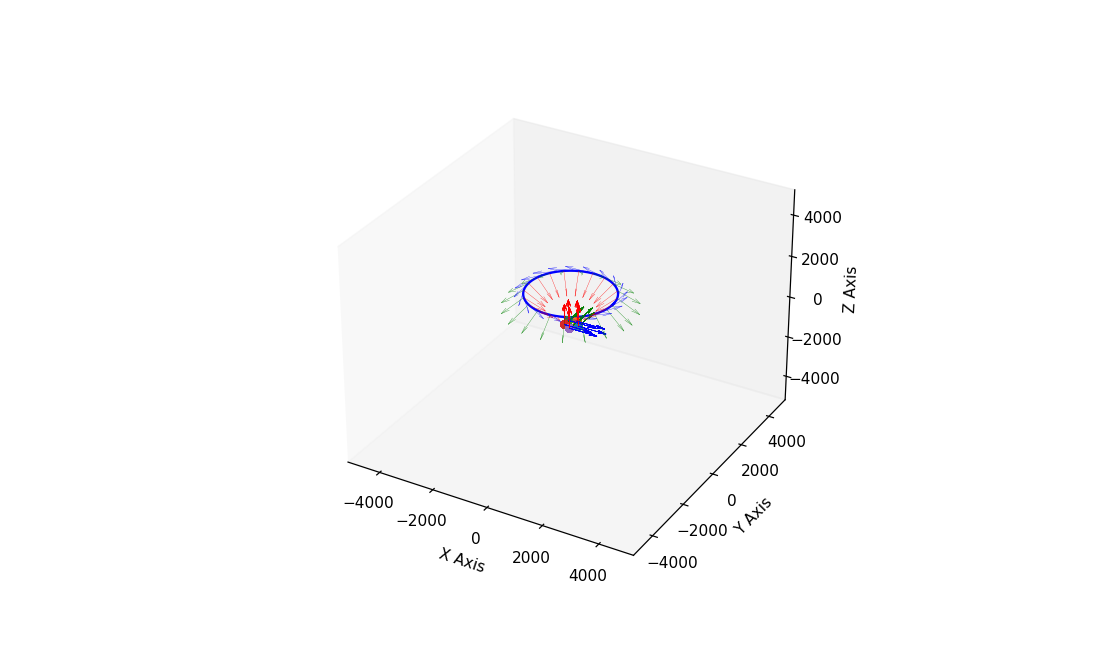

In [15]:
# all object poses
gt_pose_data_all = [[] for _ in range(len(object_pose['1']))]

idx = 0
for c in camera_pose:

    for o in range(len(object_pose['1'])):
        
        object2camera = np.column_stack((np.array(object_pose[c][o]['cam_R_m2c']).reshape(3,3),
                                         np.array(object_pose[c][o]['cam_t_m2c']).reshape(3,1)))
        object2camera = np.row_stack((object2camera, np.array([0. , 0., 0.,1.])))
        
        # given W with respect to C and M with respect to C
        # We need M with respect to W. In other words,
        # we need W_T_M = inv(C_T_W) @ C_T_M = W_T_C @ C_T_M 
        gt_pose_data_all[o].append(np.dot(gt_traj[idx], object2camera))
             
    idx+=1
    

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('X Axis')
# ax.set_ylabel('Z Axis')
# ax.set_zlabel('Y Axis')
# ax.set_xlim((-700, 100))
# ax.set_ylim((-800, 200))
# ax.set_zlim((-100, 500))
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_xlim((-5000, 5000))
ax.set_ylim((-5000, 5000))
ax.set_zlim((-5000, 5000))

plot_traj(gt_traj, ax, length=1000, c = 'blue')

# plotting as poses
for o in range(len(object_pose['1'])):
    plot_traj(gt_pose_data_all[o], ax, length=1000)


# plotting as points
for o in range(len(object_pose['1'])):
    subset_t = np.array([l[:3, -1] for l in gt_pose_data_all[o]])
    ax.scatter(subset_t[:, 0], subset_t[:, 1], subset_t[:, 2])

ax.grid(False)

plt.show()

#### Averaging and taking a single object pose

<IPython.core.display.Javascript object>


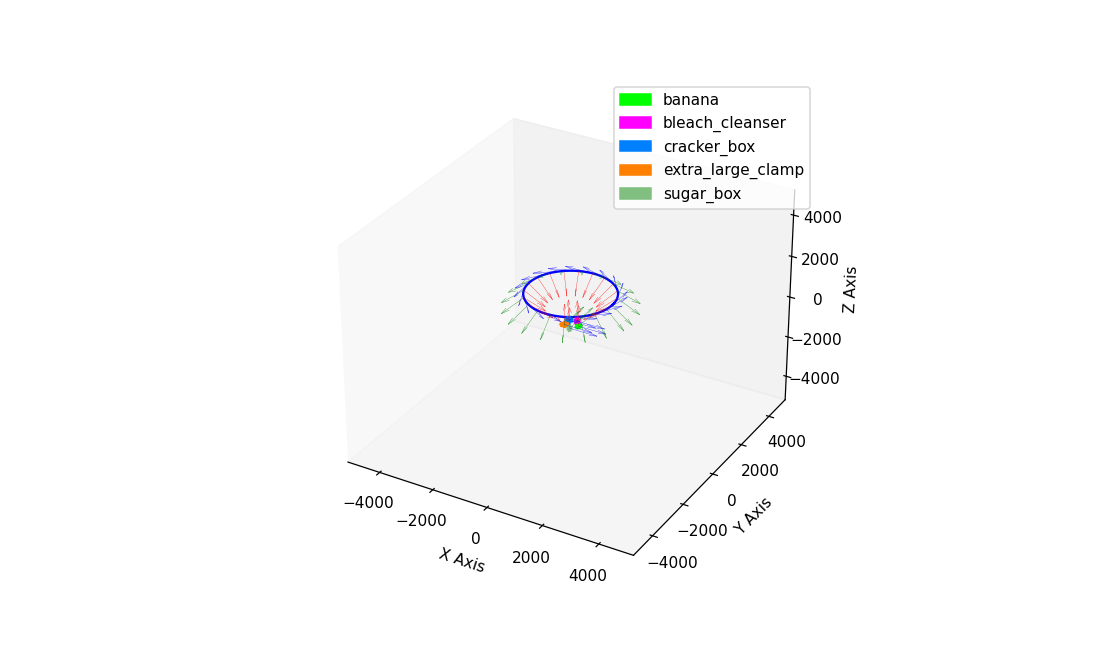

In [16]:
gt_pose = []

for obj in gt_pose_data_all:
    arrays_stack = np.stack(obj)
    gt_pose.append(np.mean(arrays_stack, axis=0))
    
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('X Axis')
# ax.set_ylabel('Z Axis')
# ax.set_zlabel('Y Axis')
# ax.set_xlim((-700, 100))
# ax.set_ylim((-800, 200))
# ax.set_zlim((-100, 500))
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_xlim((-5000, 5000))
ax.set_ylim((-5000, 5000))
ax.set_zlim((-5000, 5000))
plot_traj(gt_traj, ax, c = 'blue', length=1000)

# plotting as poses
for o in range(len(object_pose['1'])):
    plot_traj([gt_pose[o]], ax, length=1000)
    

# plotting as ellipsoids and cuboids
for o in range(len(object_pose['1'])):
    class_id = str(classes[o])
    radii = np.array([model_data[class_id]['size_x'],
                      model_data[class_id]['size_y'],
                      model_data[class_id]['size_z']])
    # plotting as ellipsoids
    plot_ellipsoid(gt_pose[o], radii/2, ax, colors[o])
    # plotting as cuboids
    plot_cuboid(gt_pose[o], radii, ax, colors[o])
    
ax.legend(handles=[
        Patch(facecolor=c, edgecolor=c, label=dataset_info[str(l)]) for l, c in zip(classes, colors)
    ])
ax.grid(False)
plt.show()

# OUTPUT DATA PROCESSING

## Reading Output File

In [17]:
## output_batch.json, output_incre.json
output_path = output_data_path + "output_batch.json"

with open(output_path, 'r') as file:
    output_data = json.load(file)

### Estimated Camera Poses

In [18]:
unaligned_traj = []

for k,v in output_data['poses'].items():
    unaligned_traj.append(np.array(output_data['poses'][k]))

In [19]:
unaligned_traj

[array([[-4.37113883e-08,  7.29537249e-01, -6.83941126e-01,
          1.50000000e+03],
        [ 1.00000000e+00,  5.30899023e-08, -7.28181115e-09,
         -4.92183229e-21],
        [ 3.09980130e-08, -6.83941126e-01, -7.29537249e-01,
          1.60000002e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[-1.06328795e-02,  7.29532026e-01, -6.83864083e-01,
          1.49991464e+03],
        [ 9.99942923e-01,  7.05932005e-03, -8.01661107e-03,
          1.60010141e+01],
        [-1.02075879e-03, -6.83910314e-01, -7.29565443e-01,
          1.60000001e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[-2.10976831e-02,  7.29432896e-01, -6.83727070e-01,
          1.49965913e+03],
        [ 9.99774927e-01,  1.38774296e-02, -1.60448232e-02,
          3.20002035e+01],
        [-2.21524727e-03, -6.83911702e-01, -7.29561453e-01,
          1.59998366e+03],
        [ 0.00000000e+00,  0.00000000e+

### Estimated Object Poses

In [20]:
unaligned_quad = output_data['quadrics']

for k,v in unaligned_quad.items():
    unaligned_quad[k]['pose'] = np.array(v['pose'])
    unaligned_quad[k]['centroid'] = np.array(v['centroid'])
    unaligned_quad[k]['radii'] = np.abs(np.array(v['radii']))

In [21]:
unaligned_quad

{'8142508126285856768': {'pose': array([[-4.00748034e-01, -9.15460124e-01, -3.65208698e-02,
           4.01006296e+02],
         [-9.16089369e-01,  3.99800481e-01,  3.06568755e-02,
           2.53216204e+01],
         [-1.34640857e-02,  4.57420631e-02, -9.98862544e-01,
           2.47084580e+02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           1.00000000e+00]]),
  'centroid': array([401.00629585,  25.32162038, 247.0845802 ]),
  'radii': array([90.04293188, 35.74970042, 16.79846415])},
 '8142508126285856769': {'pose': array([[ 9.88140982e-01,  1.50783415e-01,  2.90131177e-02,
           2.22972189e+02],
         [ 1.51874787e-01, -9.87588285e-01, -4.00428229e-02,
           2.26967215e+02],
         [ 2.26152216e-02,  4.39743154e-02, -9.98776657e-01,
           2.63447911e+02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           1.00000000e+00]]),
  'centroid': array([222.9721891 , 226.96721524, 263.44791111]),
  'radii': array([ 50.44209033, 

### Labels of quadrics

In [22]:
# to store the object class label for each quadric key
labels = output_data['labels']
labels

{'8142508126285856768': 10,
 '8142508126285856769': 12,
 '8142508126285856770': 2,
 '8142508126285856771': 20,
 '8142508126285856772': 3}

## Aligning the estimated poses with the ground truth poses

### Aligning the estimated camera pose with origin

In [23]:
est_traj_origin = np.linalg.inv(unaligned_traj[0])

origin_aligned_traj = []

for traj in unaligned_traj:
    origin_aligned_traj.append(np.dot(est_traj_origin, traj))

### Aligning the estimated camera pose with ground truth

In [24]:
aligned_traj = []

for traj in origin_aligned_traj:
    aligned_traj.append(np.dot(gt_traj[0], traj))

### Plotting Aligned Estimated Camera Pose and Ground Truth Camera Pose

<IPython.core.display.Javascript object>


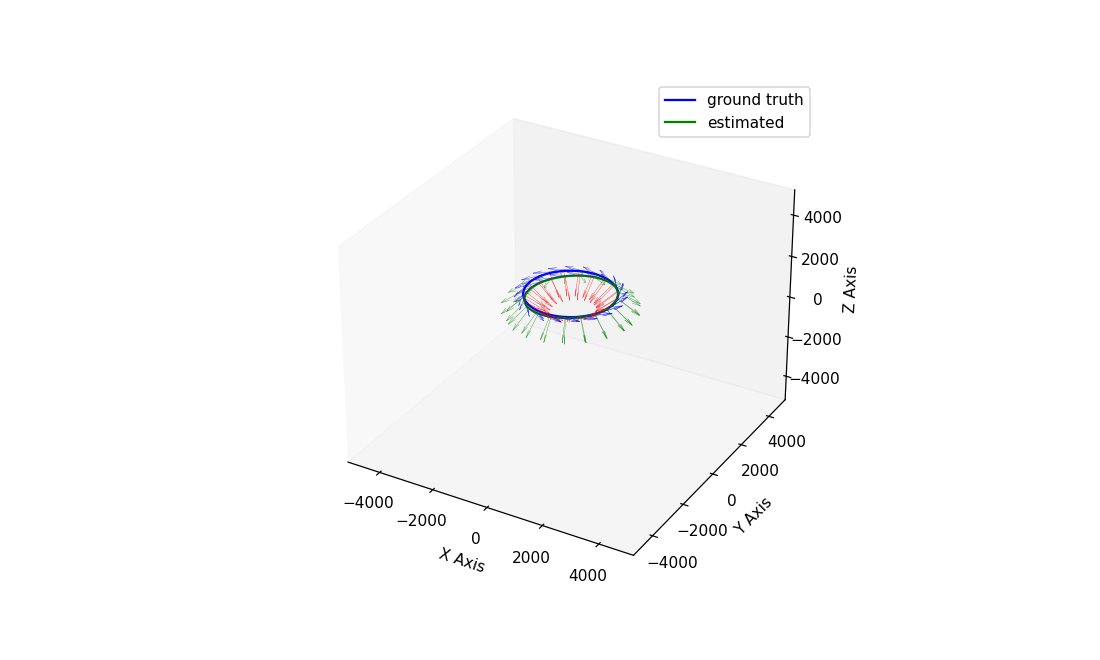

In [29]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('X Axis')
# ax.set_ylabel('Z Axis')
# ax.set_zlabel('Y Axis')
# ax.set_xlim((-700, 100))
# ax.set_ylim((-800, 200))
# ax.set_zlim((-100, 500))
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_xlim((-5000, 5000))
ax.set_ylim((-5000, 5000))
ax.set_zlim((-5000, 5000))

plot_traj(gt_traj, ax, c = 'blue', label="ground truth", length = 1000)
plot_traj(aligned_traj, ax, c = 'green', label="estimated", length = 1000)

ax.legend()
ax.grid(False)
plt.show()

### Aligning the estimated object pose with origin

In [27]:
origin_aligned_quad = unaligned_quad

for k,v in origin_aligned_quad.items():
    origin_aligned_quad[k]['pose'] = np.dot(est_traj_origin, v['pose'])

### Aligning the estimated object pose with ground truth

In [28]:
aligned_quad = origin_aligned_quad

for k,v in aligned_quad.items():
    aligned_quad[k]['pose'] = np.dot(gt_traj[0], v['pose'])

### Plotting Aligned Estimated Object Pose and Ground Truth Object Pose

<IPython.core.display.Javascript object>


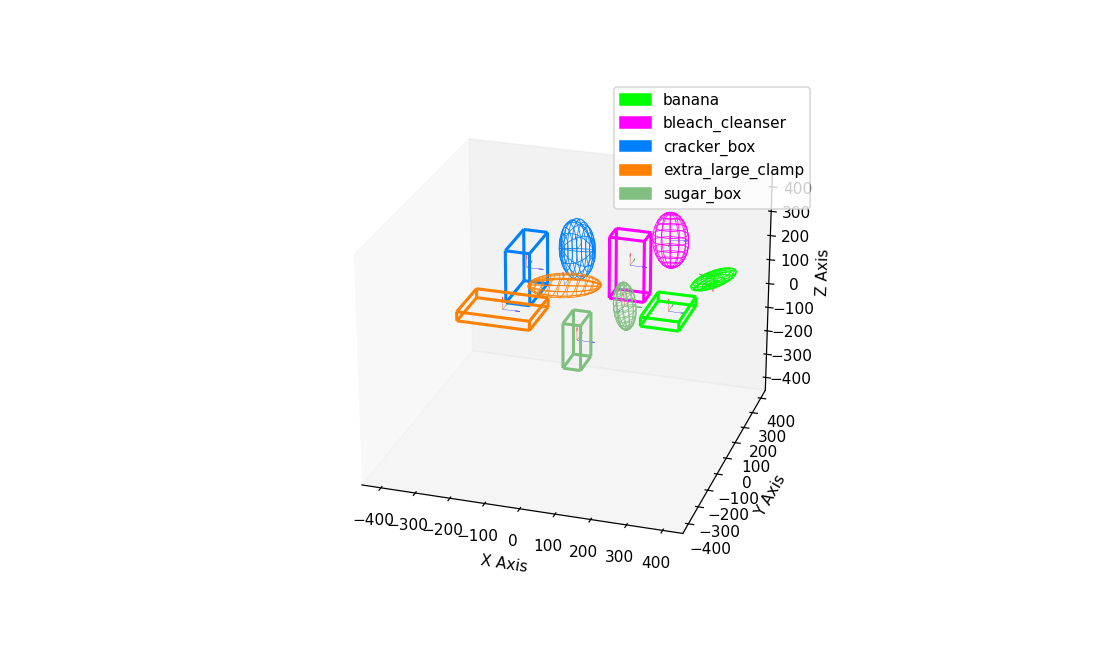

In [30]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('X Axis')
# ax.set_ylabel('Z Axis')
# ax.set_zlabel('Y Axis')
# ax.set_xlim((-700, 100))
# ax.set_ylim((-800, 200))
# ax.set_zlim((-100, 500))
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_xlim((-5000, 5000))
ax.set_ylim((-5000, 5000))
ax.set_zlim((-5000, 5000))

# plotting GT object pose as cuboid
for o in range(len(object_pose['1'])):
    plot_traj([gt_pose[o]], ax)
    
    class_id = str(classes[o])
    radii = np.array([model_data[class_id]['size_x'],
                      model_data[class_id]['size_y'],
                      model_data[class_id]['size_z']])
    # plotting as ellipsoids
    # plot_ellipsoid(gt_pose[o], radii/2, ax, colors[o])
    # plotting as cuboids
    plot_cuboid(gt_pose[o], radii, ax, colors[o])
    
    
# plotting estimated object pose as ellipsoids
for k,v in aligned_quad.items():
    plot_traj([v['pose']], ax)
    
    plot_ellipsoid(v['pose'], v['radii'],
                   ax, colors[classes.index(labels[k])])
    
    
ax.legend(handles=[
        Patch(facecolor=c, edgecolor=c, label=dataset_info[str(l)]) for l, c in zip(classes, colors)
    ])
ax.grid(False)
plt.show()

## Plot Trajectory and Object Pose for Ground Truth and Estimated Aligned

<IPython.core.display.Javascript object>


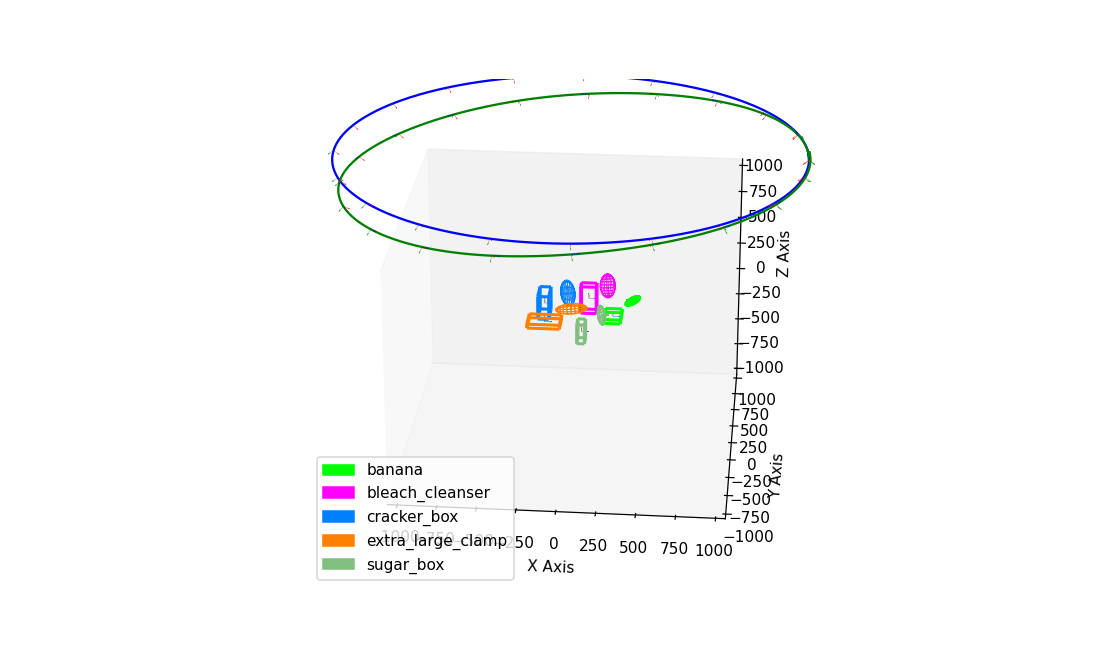

In [31]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('X Axis')
# ax.set_ylabel('Z Axis')
# ax.set_zlabel('Y Axis')
# ax.set_xlim((-700, 100))
# ax.set_ylim((-800, 200))
# ax.set_zlim((-100, 500))
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_xlim((-5000, 5000))
ax.set_ylim((-5000, 5000))
ax.set_zlim((-5000, 5000))

## plotting trajectories
plot_traj(gt_traj, ax, c = 'blue', label="ground truth")
plot_traj(aligned_traj, ax, c = 'green', label="estimated")

# plotting GT object pose as cuboid
for o in range(len(object_pose['1'])):
    plot_traj([gt_pose[o]], ax)
    
    class_id = str(classes[o])
    radii = np.array([model_data[class_id]['size_x'],
                      model_data[class_id]['size_y'],
                      model_data[class_id]['size_z']])
    # plotting as ellipsoids
    # plot_ellipsoid(gt_pose[o], radii/2, ax, colors[o])
    # plotting as cuboids
    plot_cuboid(gt_pose[o], radii, ax, colors[o])
    
    
# plotting estimated object pose as ellipsoids
for k,v in aligned_quad.items():
    plot_traj([v['pose']], ax)
    
    plot_ellipsoid(v['pose'], v['radii'],
                   ax, colors[classes.index(labels[k])])
    
    
ax.legend(handles=[
        Patch(facecolor=c, edgecolor=c, label=dataset_info[str(l)]) for l, c in zip(classes, colors)
    ])
ax.grid(False)
plt.show()

# Processed data


- **Ground truth trajectory/camera poses** -> gt_traj(list(np.ndarray))
- **Ground truth object poses** -> gt_pose(list(np.ndarray)) -> radius from model_data[class_id]['size_x']/2, model_data[class_id]['size_y']/2, model_data[class_id]['size_z']/2


- **Estimated trajectory/camera poses** -> aligned_traj(list(np.ndarray))
- **Estimated object poses** -> aligned_quad(dict of quadric id and their pose, radius)

# Export data

In [28]:
export_data = {'ground_truth_camera_pose': [],
               'ground_truth_object_pose': dict(),
               'estimated_camera_pose': [],
               'estimated_object_pose': dict()}

## CAMERA POSES
for item in gt_traj:
    export_data['ground_truth_camera_pose'].append(item.tolist())
for item in aligned_traj:
    export_data['estimated_camera_pose'].append(item.tolist())


## GT OBJECT POSE
export_data['ground_truth_object_pose']['pose'] = []
for item in gt_pose:
    export_data['ground_truth_object_pose']['pose'].append(item.tolist())
    
export_data['ground_truth_object_pose']['radius'] = []
export_data['ground_truth_object_pose']['label'] = classes

for o in range(len(object_pose['1'])):
    class_id = str(classes[o])
    radii = [model_data[class_id]['size_x']/2,
             model_data[class_id]['size_y']/2,
             model_data[class_id]['size_z']/2]
    export_data['ground_truth_object_pose']['radius'].append(radii)
    

## ESTIMATED OBJECT POSE
export_data['estimated_object_pose']['pose'] = []
export_data['estimated_object_pose']['radius'] = []
export_data['estimated_object_pose']['label'] = []

for k,v in aligned_quad.items():
    export_data['estimated_object_pose']['pose'].append(v['pose'].tolist())
    export_data['estimated_object_pose']['radius'].append(v['radii'].tolist())
    export_data['estimated_object_pose']['label'].append(labels[k])

In [29]:
# aligned_output_quadricslam_batch.json or aligned_output_quadricslam_incre.json
with open(export_path + 'aligned_output_quadricslam_batch.json', "w") as json_file:
    json.dump(export_data, json_file, indent=4)  # indent for pretty formatting